**Exercise**

Load images from the Cat_Dog_data/train folder, define a few transforms, then build the dataloader.

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch import nn,optim
import torch.nn.functional as F

from collections import OrderedDict

import helper

In [10]:
data_dir = 'images/Cat_Dog_Data'

#training transform
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(244),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
#test transforms
test_transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])

#Training and Test dataset

train_data = datasets.ImageFolder(data_dir+ '/train', transform=train_transform)
test_data = datasets.ImageFolder(data_dir+ '/test', transform=test_transform)

#Dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


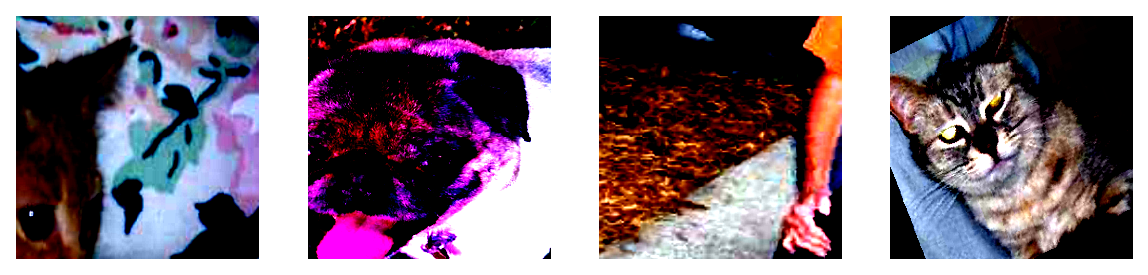

In [11]:
# Run this to test your data loader
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize =(10,4), ncols = 4)

for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax = ax, normalize=False)
    

In [41]:
model = models.resnet34(pretrained=True)

In [42]:
model.fc.parameters

<bound method Module.parameters of Linear(in_features=512, out_features=1000, bias=True)>

In [30]:
#Freeze parameter so we dont backdrop through them
for param in model.parameters():
    param.requires_grad=False
    

classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(512,256)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(256,2)),
    ('output',nn.LogSoftmax(dim=1))
]))

model.fc = classifier

In [32]:
torch.cuda.is_available()

False

In [53]:
device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")

#device

model = models.resnet34(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)

#Freeze parameter so we dont backdrop through them
for param in model.parameters():
    param.requires_grad=False

model.fc = nn.Sequential(nn.Linear(512,128),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(128,2),
                        nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

#only train the fc parameters for model. Features are frozen
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [38]:
device

device(type='cpu')

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    
    for images,labels in trainloader:
        steps += 1
        
        #Move input and label tensor to default device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps%print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    
                    output = model(images)
                    batch_loss = criterion(output,labels)
                    
                    test_loss += batch_loss.item()
                    
                    #Calculate accuracy
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1,dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}"
                 f"Train loss: {running_loss/print_every:.3f}"
                 f"Test Loss: {test_loss/len(testloader):.3f}"
                 f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    
                    

Epoch 1/1Train loss: 1.407Test Loss: 0.737Test accuracy: 0.512
Epoch 1/1Train loss: 0.723Test Loss: 0.571Test accuracy: 0.909
Epoch 1/1Train loss: 0.597Test Loss: 0.495Test accuracy: 0.913
Epoch 1/1Train loss: 0.558Test Loss: 0.383Test accuracy: 0.967
Epoch 1/1Train loss: 0.513Test Loss: 0.322Test accuracy: 0.967
Epoch 1/1Train loss: 0.424Test Loss: 0.269Test accuracy: 0.970
Epoch 1/1Train loss: 0.383Test Loss: 0.227Test accuracy: 0.945
Epoch 1/1Train loss: 0.361Test Loss: 0.167Test accuracy: 0.969
Epoch 1/1Train loss: 0.343Test Loss: 0.143Test accuracy: 0.972
